## China as a Global Creditor - a Data Exercise

#### 1. China’s International Investment Position 
Visit the website of China’s State Administration of Foreign Exchange (SAFE) and download time series data on China’s International Investment Position.

Data-Source: https://www.safe.gov.cn/en/2018/0329/1412.html


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown


# Import Excel
SAFE_data_raw = pd.read_excel(
    r"C:\Users\jonaw\OneDrive\Dokumente\Coding\Computational Economics"
    r"\Data Viz\China as a Global Creditor - a Data Excercise"
    r"\data\The time-series data of International Investment Position of China.xlsx",
    sheet_name="Annual(USD)",
    header=2
)

# Replace / with NaN
SAFE_data_raw.replace("/", np.nan, inplace=True)
SAFE_data_raw = SAFE_data_raw.infer_objects()

# Create side for Assets and Liabilities
SAFE_data_raw['Side'] = (
    SAFE_data_raw['Item']
      .where(SAFE_data_raw['Item'].isin(['Assets','Liabilities']))
      .ffill()
)


# Drop first row and rows from 50
SAFE_data_raw = SAFE_data_raw.iloc[1:].reset_index(drop=True)
SAFE_data_raw = SAFE_data_raw.iloc[:50].copy()




C:\Users\jonaw\AppData\Local\Temp\ipykernel_5944\2408200753.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  SAFE_data_raw.replace("/", np.nan, inplace=True)


In [4]:
# Transform the data to long format
SAFE_data_long = (
    SAFE_data_raw
      .melt(id_vars=['Side','Item'], var_name='Year', value_name='Value')
      .rename(columns={'Item':'Category'})
)

# Clean up Year: remove “end-” and make it integer
SAFE_data_long["Year"] = (
    SAFE_data_long["Year"]
      .str.replace("end-", "", regex=False)
      .astype(int)
)

# Set value to numeric
SAFE_data_long["Value"] = pd.to_numeric(SAFE_data_long["Value"], errors="coerce")

SAFE_data_long.head()


,Side,Category,Year,Value
0,NaN,Net International Investment Position,2004,2407.831855
1,Assets,Assets,2004,9361.972409
2,Assets,1 Direct investment,2004,596.393975
3,Assets,1.1 Equity and investment fund shares,2004,583.393475
4,Assets,1.2 Debt instruments,2004,13.000500


**Question 1a**. Is China a net creditor or a net debtor towards the rest of the world? How has its net asset position evolved over the past 20 years?

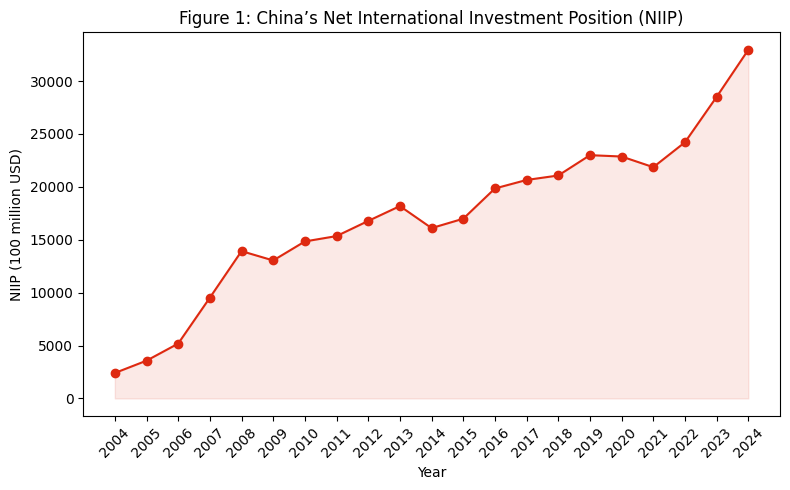

NIIP change (2004-2024):1268.77%


In [5]:
# Define the Net International Investment Position (NIIP) (Assets - Liabilities)
niip = SAFE_data_long[SAFE_data_long["Category"] == "Net International Investment Position"]

plt.figure(figsize=(8,5))
plt.plot(niip.Year, niip.Value, 'o-', color="#DE2910" )

# Set x-ticks
plt.xticks(niip.Year, rotation=45)

# Shade under the line
plt.fill_between(niip.Year,niip.Value,color="#DE2910",alpha=0.1)

plt.title("Figure 1: China’s Net International Investment Position (NIIP)")
plt.xlabel("Year")
plt.ylabel("NIIP (100 million USD)")
plt.tight_layout()
plt.show()

# grab 2004 and 2024
NIIP_2004 = niip.loc[niip.Year == 2004, "Value"].item()
NIIP_2024= niip.loc[niip.Year == 2024, "Value"].item()

NIIP_change  = (NIIP_2024 / NIIP_2004 - 1) * 100
print(f"NIIP change (2004-2024):{NIIP_change:.2f}%")

**Answer 1.a** : Over the last twenty years China has been a net creditor for the rest a the world, as its external assets exceeds its liabilities by far. The NIIP increased by about 1.269% (not inflation-adjusted).

**Question 1b**. Show graphically how the composition of China’s external assets and liabilities looked in 2007 at the onset of the Global Financial Crisis and how it looks today. Explain how China’s investments and liabilities have evolved over time. Which types of assets and liabilities have become more or less important?

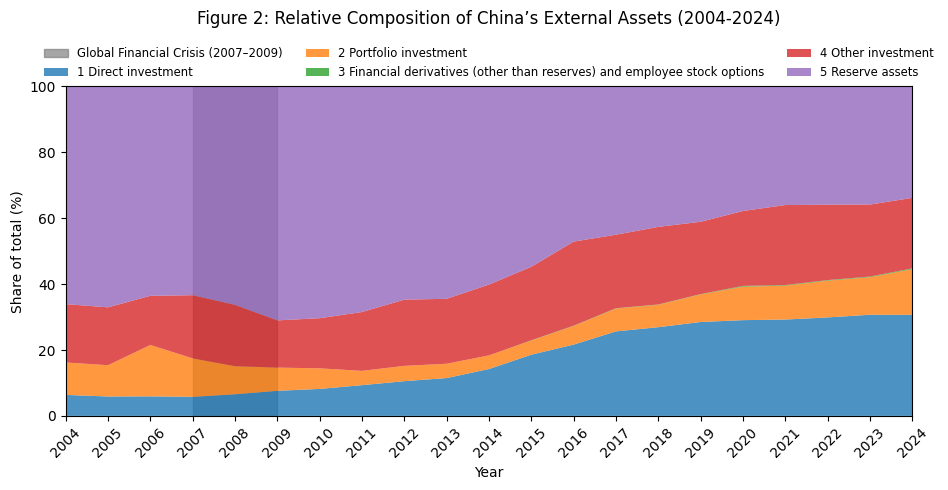

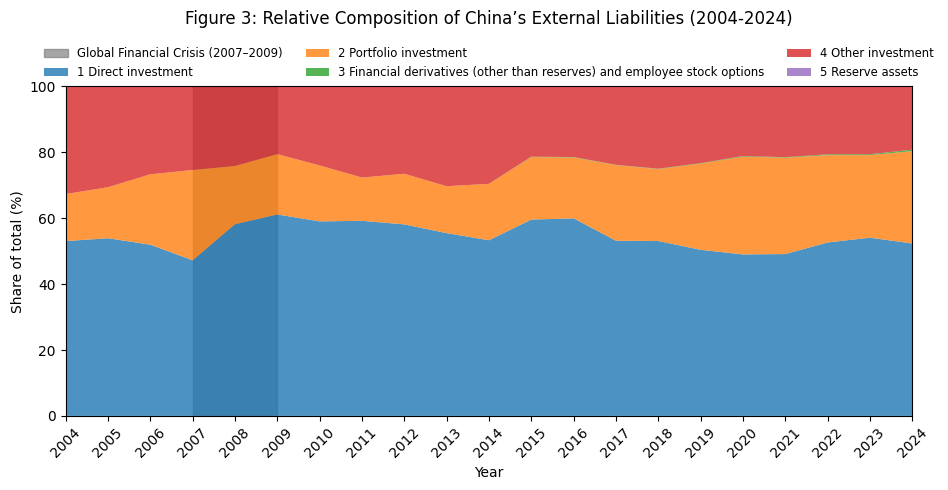

In [6]:

# Clean Category names
SAFE_data_long['Category_clean'] = (
    SAFE_data_long['Category']
      .astype(str) # Convert to string
      .str.strip() # Remove leading/trailing spaces
      .str.replace(' +', '_', regex=True) # Replace spaces with underscores
)

# Define the top balance categories
top5 = [
    "1_Direct_investment",
    "2_Portfolio_investment",
    "3_Financial_derivatives_(other_than_reserves)_and_employee_stock_options",
    "4_Other_investment",
    "5_Reserve_assets"
]

# Filter the data for the top 5 categories and create a new Dataframe
df_top5 = SAFE_data_long[
    SAFE_data_long['Category_clean'].isin(top5)
].copy()

# Pivot to wide format
pivot = df_top5.pivot_table(
    index='Year',
    columns=['Side','Category_clean'],
    values='Value',
    aggfunc='sum'
)

#Compute relative shares (%) for Assets
assets = pivot['Assets'].reindex(columns=top5, fill_value=0)
assets_pct = assets.div(assets.sum(axis=1), axis=0) * 100

#Compute relative shares (%) for Liabilities
liabs = pivot['Liabilities'].reindex(columns=top5, fill_value=0)
liabs_pct = liabs.div(liabs.sum(axis=1), axis=0) * 100

# Create labels for the legend
labels = [c.replace('_', ' ') for c in top5]


# Plot 1: Assets
#----------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10,5))

# Shade the crisis and label it
ax.axvspan(2007, 2009, color='grey', alpha=0.7, label='Global Financial Crisis (2007–2009)')

# Set the stacked area
ax.stackplot(assets_pct.index, assets_pct.T, labels=labels, alpha=0.8)

# Formatting
ax.set_title(
    "Figure 2: Relative Composition of China’s External Assets (2004-2024)\n",
    pad=30
)
ax.set_xlabel("Year")
ax.set_ylabel("Share of total (%)")
ax.set_ylim(0, 100)

# X‐ticks as integers, rotated
ax.set_xticks(assets_pct.index)
ax.set_xticklabels(assets_pct.index.astype(int), rotation=45)

# Pin x‐axis to data range
ax.set_xlim(assets_pct.index.min(), assets_pct.index.max())

# Legend between title and plot
handles, labs = ax.get_legend_handles_labels()
ax.legend(
    handles, labs,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize='small',
    frameon=False
)

plt.tight_layout()
plt.show()


# Plot 2: Liabilities
#----------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10,5))

# Shade the crisis and label it
ax.axvspan(2007, 2009, color='grey', alpha=0.7, label='Global Financial Crisis (2007–2009)')

# Set stacked area
ax.stackplot(liabs_pct.index, liabs_pct.T, labels=labels, alpha=0.8)

# Formatting
ax.set_title(
    "Figure 3: Relative Composition of China’s External Liabilities (2004-2024)\n",
    pad=30
)
ax.set_xlabel("Year")
ax.set_ylabel("Share of total (%)")
ax.set_ylim(0, 100)

# X‐ticks as integers, rotated
ax.set_xticks(liabs_pct.index)
ax.set_xticklabels(liabs_pct.index.astype(int), rotation=45)

# Pin x‐axis to data range
ax.set_xlim(liabs_pct.index.min(), liabs_pct.index.max())

# Legend between title and plot
handles, labs = ax.get_legend_handles_labels()
ax.legend(
    handles, labs,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize='small',
    frameon=False
)

plt.tight_layout()
plt.show()

**Answer 1b:** 
During the global financial crisis china accumulated more reserve assets from roughly 55% to over 70% by 2008, while both direct and portfolio investment shares contracted below 10%. On the liability side, portfolio investment’s share plunged from about 25 % to under 20 % by 2009.

Long term, we can observe that China’s external assets have gradually rebalanced away from pure reserve accumulation toward higher-return allocation.Ddirect investment now accounts for roughly 30 % and portfolio investment about 15 % of assets (down from reserves’ 70 % in 2008 to 35 % today). On the liability side, foreign direct investment has stayed around 50 % of the total while portfolio liabilities have climbed steadily from below 20 % in 2009 to nearly 30 % by 2024, reflecting China’s deepening integration into global capital markets.










**Question 1c.** Compare China’s international investment position to that of the US. Which asset and liability categories are more important on the US balance sheet?

Data-Source: https://www.bea.gov/data/intl-trade-investment/international-investment-position



In [7]:

# Import US IIP data
US_IIP_data = pd.read_excel(
    r"C:\Users\jonaw\OneDrive\Dokumente\Coding\Computational Economics"
    r"\Data Viz\China as a Global Creditor - a Data Excercise"
    r"\data\intinv424.xlsx",
    sheet_name="Table 1"
)

# Skip rows 0–2, keep up to row 65
US_IIP_data = US_IIP_data.iloc[3:66].reset_index(drop=True)

# Rename columns
US_IIP_data.rename(
    columns={
        US_IIP_data.columns[1]: "Category",
        US_IIP_data.columns[6]: "US_2024_Q4"
    },
    inplace=True
)

# Keep only Category and Q4, then drop the first data row
US_IIP_data = US_IIP_data[["Category", "US_2024_Q4"]].iloc[1:].reset_index(drop=True)

# Create Side column
US_IIP_data["Side"] = pd.NA
US_IIP_data.loc[4:35, "Side"] = "Assets"
US_IIP_data.loc[37:,  "Side"] = "Liabilities"

# Keep only relevant rows
keep_rows = [7, 10, 15, 21, 27, 40, 43, 52, 58]
US_IIP_data = US_IIP_data.loc[keep_rows].reset_index(drop=True)

# Filter SAFE data for 2024 and select the correct positions with iloc
SAFE_data_2024 = SAFE_data_long[SAFE_data_long["Year"] == 2024][
    ["Category_clean", "Value", "Side"]
].reset_index(drop=True)
SAFE_data_2024 = SAFE_data_2024.iloc[[2, 11, 14, 15, 22, 29, 38, 41, 42]].reset_index(drop=True)

# Merge by index
US_China_IIP = US_IIP_data.merge(
    SAFE_data_2024,
    left_index=True,
    right_index=True,
    suffixes=("_US", "_SAFE")
)

# Convert types, rename, drop columns, and scale values
US_China_IIP["US_2024_Q4"] = pd.to_numeric(US_China_IIP["US_2024_Q4"], errors="coerce")
US_China_IIP.rename(columns={"Value": "China_2024_Q4"}, inplace=True)
US_China_IIP.drop(columns=["Side_SAFE", "Category"], inplace=True)
US_China_IIP["China_2024_Q4"] *= 0.1  # Convert from 100 million USD to billion USD

# Calculate percentage columns
US_China_IIP["China_2024_Q4_pct"] = (
    US_China_IIP["China_2024_Q4"] / US_China_IIP["China_2024_Q4"].sum() * 100
)
US_China_IIP.rename(columns={"Side_US": "Side"}, inplace=True)
US_China_IIP["US_pct"] = (
    US_China_IIP.groupby("Side")["US_2024_Q4"]
    .transform(lambda x: x / x.sum() * 100)
)
US_China_IIP["China_pct"] = (
    US_China_IIP.groupby("Side")["China_2024_Q4"]
    .transform(lambda x: x / x.sum() * 100)
)
US_China_IIP[["US_pct", "China_pct"]] = US_China_IIP[["US_pct", "China_pct"]].round(1)

# Final renaming and column ordering
Table_1c = US_China_IIP.rename(columns={
    "Category_clean": "Category",
    "US_2024_Q4":     "US (bn USD)",
    "China_2024_Q4":  "China (bn USD)",
    "US_pct":         "US share (%)",
    "China_pct":      "China share (%)"
})
for c in ["US (bn USD)", "China (bn USD)"]:
    Table_1c[c] = Table_1c[c].round(1)

Table_1c = Table_1c[[
    "Side",
    "Category",
    "US (bn USD)",
    "China (bn USD)",
    "US share (%)",
    "China share (%)"
]]
display(Markdown("### Table 1: Comparison of US and Chinese International Investment Positions (2024 Q4)"))
display(Table_1c)

### Table 1: Comparison of US and Chinese International Investment Positions (2024 Q4)

,Side,Category,US (bn USD),China (bn USD),US share (%),China share (%)
0,Assets,1_Direct_investment,11265.4,3132.9,31.4,30.7
1,Assets,2_Portfolio_investment,15873.1,1417.3,44.2,13.9
2,Assets,3_Financial_derivatives_(other_than_reserves)_...,2316.2,24.2,6.5,0.2
3,Assets,4_Other_investment,5520.8,2186.7,15.4,21.4
4,Assets,5_Reserve_assets,909.9,3455.6,2.5,33.8
5,Liabilities,1_Direct_investment,17837.2,3622.4,28.7,52.3
6,Liabilities,2_Portfolio_investment,33086.9,1939.6,53.3,28.0
7,Liabilities,3_Financial_derivatives_(other_than_reserves)_...,2284.0,30.4,3.7,0.4
8,Liabilities,4_Other_investment,8909.5,1328.6,14.3,19.2


**Answer 1c:** In comparing the U.S. and Chinese IIP shares in Table 1c, four categories stand out as significantly more important for the United States than for China:

- **Portfolio Investment Assets & Liabilities:** US investors hold a far larger share of their external balance sheet in portfolio instruments than Chinese investors—evidence of the United States’ open, two-way access to global capital markets. Conversely, the United States attracts more portfolio inflows than China, chiefly because the U.S. dollar’s reserve-currency status makes Treasuries and corporate bonds the preferred parking place for foreign savings. China, by contrast, shows a much higher share of official reserves: foreign securities held directly by SAFE and the PBoC are booked as reserves rather than private portfolio assets. This contrast highlights the divergent economic models—market-driven intermediation in the United States versus state-centred, precautionary reserve accumulation in China.
  
- **Financial derivative Assets & Liablities:** The US hosts the world’s largest derivatives intermediaries resulting in outsized net positions in cross‑border derivatives. Chinese banks and regulators, by contrast, maintain tighter controls on offshore derivative transactions, which limits the scale of China’s recorded positions in this category.
  
 



**1d**. Is China’s International Investment Position becoming more similar to that of the US? What are the risk and return implications for China?

In the plots from 1b we can see that that about 70% of China's foreign assets sat as reserve assets, which yields very low yield. In 2024 the Reserve-Asset share has fallen, while direct and portfolio investment has risen. This shows a trend to the position that the US also holds. China is trading safer, low yield, investements for higher yielding foreign direct- and portfolio Investments. This re‑allocation should boost China’s net returns, yet at the cost of greater exposure to international financial volatility and risk.

#### 2. ’Chimerica’ and China’s US investments
    
The primary destination of China’s external investments is the USA. To better understand the magnitude and evolution of China’s US investments, go to the US Treasury’s website and search for data on Foreign Portfolio Holdings of US Securities.

https://home.treasury.gov/data/treasury-international-capital-tic-system/us-liabilities-to-foreigners-from-holdings-of-us-securities

In [8]:
# Load TIC data 
ticdata_raw = pd.read_csv(
    "https://ticdata.treasury.gov/Publish/shlhistdat.txt",
    sep="\t",
    header=None,
    skiprows=5,
    encoding="utf-8",
    dtype=str,            
    low_memory=False
)


In [9]:
# Safe copy of the original data
ticdata = ticdata_raw.copy()

# Delete rows 1-4
ticdata = ticdata.iloc[4:].reset_index(drop=True)

# Delete all other countries except China and the first 2 rows
mask = (ticdata.index <= 2) | (ticdata.iloc[:, 1] == "China (20)")
ticdata = ticdata[mask].reset_index(drop=True)

# Delete first column
ticdata.drop(columns=[0], inplace=True)

# Rename rows
ticdata.iloc[0, 0] = "Date"
ticdata.iloc[1, 0] = "Category"
ticdata.iloc[2, 0] = "Position"
ticdata.iloc[3, 0] = "Million USD"

# Transpose the DataFrame
ticdata = ticdata.T.reset_index(drop=True)

# Set the first row as the header
ticdata.columns = ticdata.iloc[0]

# Just keep last 4 digits of the date
ticdata["Date"] = ticdata["Date"].str[-4:]

# Sort by smallest date first
ticdata = ticdata.iloc[1:].sort_values(by="Date").reset_index(drop=True)

# Format Date to datetime
ticdata["Date"] = pd.to_datetime(ticdata["Date"], format="%Y", errors="coerce")

# Drop Dates < 2004 
ticdata = ticdata[ticdata["Date"] >= "2004-01-01"].reset_index(drop=True)

# Convert Value to numeric
ticdata["Million USD"] = pd.to_numeric(ticdata["Million USD"], errors="coerce")

# Convert to Billion USD and rename column
ticdata["Million USD"] = ticdata["Million USD"].round(1) / 1000
ticdata.rename(columns={"Million USD": "Billion USD"}, inplace=True)


# Check data head
ticdata.head(10)



,Date,Category,Position,Billion USD
0,2004-01-01,Total,Total securities,340.972
1,2004-01-01,Long-term,Equity,2.523
2,2004-01-01,Long-term,Total long-term Debt,320.287
3,2004-01-01,Long-term,Treasury Debt,189.181
4,2004-01-01,Long-term,Agency debt,114.903
5,2004-01-01,Long-term,Corporate debt,16.203
6,2004-01-01,Short-term,Total short-term debt,18.163
7,2004-01-01,Short-term,Treasury debt,5.029
8,2004-01-01,Short-term,Agency debt,12.854
9,2004-01-01,Short-term,Corporate debt,0.279


**Question 2a.** Show graphically how Chinese portfolio holdings of US securities have evolved over the past 20 years. What may explain the observed time trend?

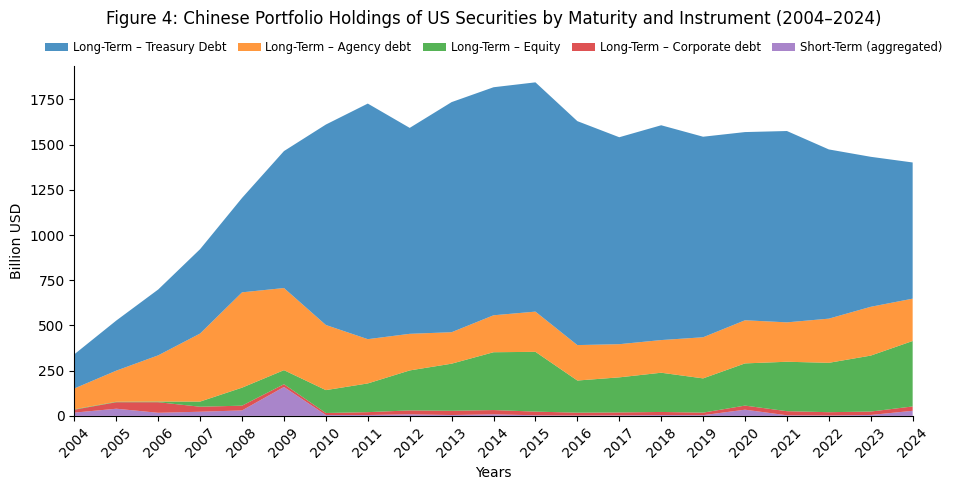

In [10]:
# Redact totals
plot_df = ticdata[
    ~ticdata["Category"].str.contains("Total", case=False, na=False) &
    ~ticdata["Position"].str.contains("Total", case=False, na=False)
].copy()

# Get Years
plot_df["Year"] = plot_df["Date"].dt.year

# Pivot by category
long_pivot = (plot_df[plot_df["Category"] == "Long-term"]
              .pivot_table(index="Year", columns="Position", values="Billion USD", aggfunc="sum")
              .fillna(0)
              .sort_index())

short_pivot = (plot_df[plot_df["Category"] == "Short-term"]
               .pivot_table(index="Year", columns="Position", values="Billion USD", aggfunc="sum")
               .fillna(0)
               .sort_index())

# Rename columns
long_pivot.columns = [f"Long-Term – {c}" for c in long_pivot.columns]

# Aggregate Short-Term positions into one column
short_aggregated = short_pivot.sum(axis=1).to_frame(name="Short-Term (aggregated)")

# Combine data
combined = pd.concat([long_pivot, short_aggregated], axis=1)
combined = combined[combined.sum().sort_values().index]

# Labels
labels = combined.columns.tolist()

# Get default colors and reverse
default_colors = [d["color"] for d in plt.rcParams["axes.prop_cycle"]]
while len(default_colors) < len(labels):
    default_colors += default_colors
colors_reversed = default_colors[:len(labels)][::-1]

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(combined.index, combined.T, labels=labels, colors=colors_reversed, alpha=0.8)

# Axes styling
ax.set_title("Figure 4: Chinese Portfolio Holdings of US Securities by Maturity and Instrument (2004–2024)", pad=30)
ax.set_xlabel("Years")
ax.set_ylabel("Billion USD")
ax.set_xticks(combined.index)
ax.set_xticklabels(combined.index.astype(int), rotation=45)
ax.set_xlim(combined.index.min(), combined.index.max())

# Legend directly below the title, horizontal
handles, labs = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labs[::-1],
                   loc='upper center',
                   bbox_to_anchor=(0.5, 1.10), 
                   fontsize='small',
                   frameon=False,
                   ncol=len(labels),               
                   columnspacing=1.0, 
                   handletextpad=0.4)   
legend.get_title().set_fontsize('medium')
# Clean up spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

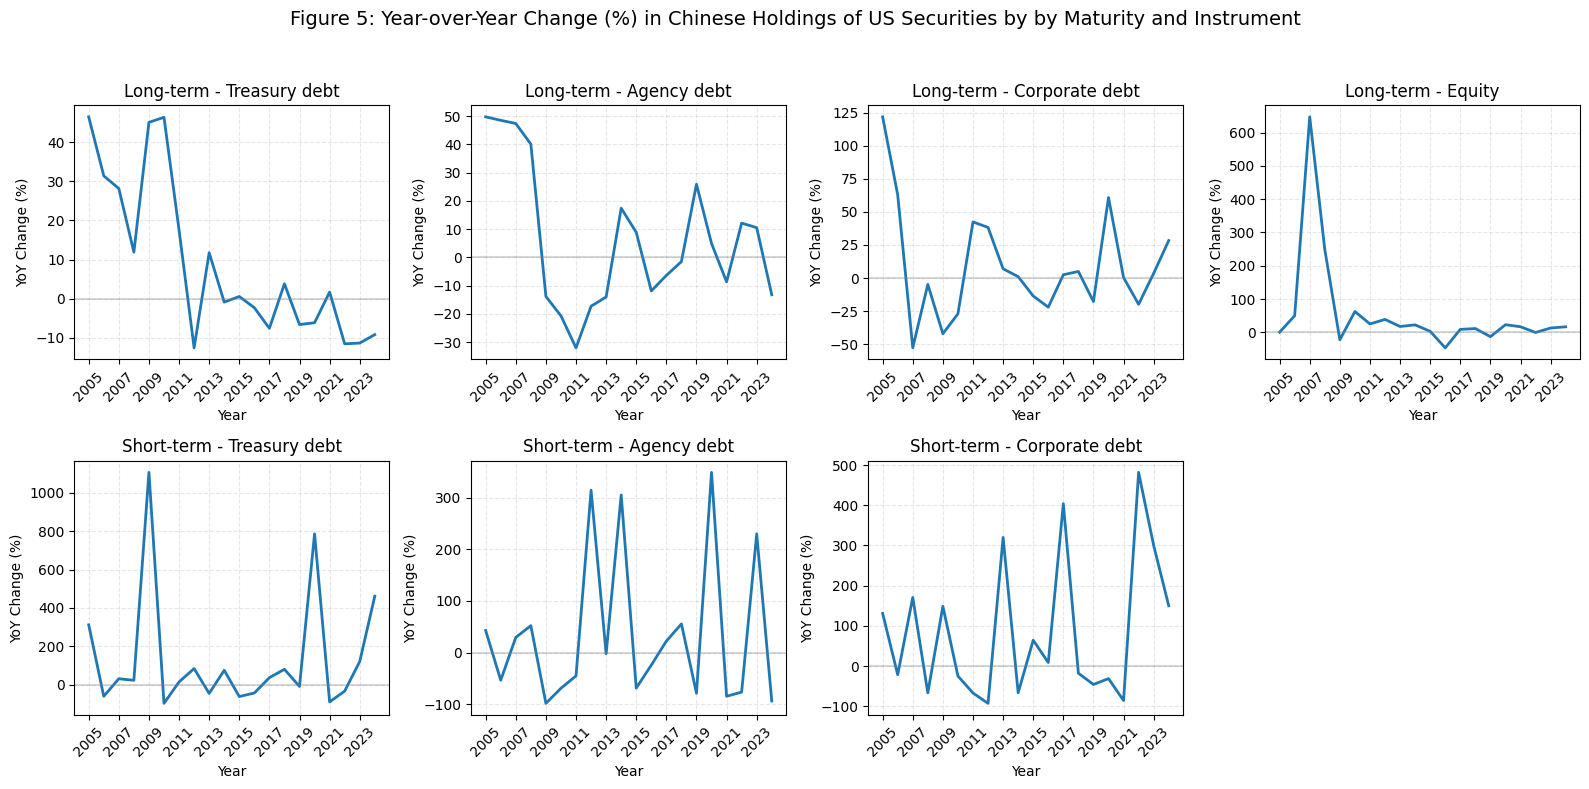

In [11]:
# Create dedicated DataFrame for facet wrap plot
df_facet_wrap = ticdata[
    ~ticdata["Category"].str.contains("Total", case=False, na=False) &
    ~ticdata["Position"].str.contains("Total", case=False, na=False)
].copy()

# Standardize Position names to avoid duplicates
df_facet_wrap["Position"] = df_facet_wrap["Position"].str.replace("Treasury Debt", "Treasury debt")

# Extract year from date
df_facet_wrap["Year"] = df_facet_wrap["Date"].dt.year

# Define positions to include in each category in the specified order
position_mapping = {
    "Long-term": ["Treasury debt", "Agency debt", "Corporate debt", "Equity"],
    "Short-term": ["Treasury debt", "Agency debt", "Corporate debt"] 
}

# Calculate YoY changes for all combinations
yoy_data = {}
for category in ["Long-term", "Short-term"]:
    category_data = df_facet_wrap[df_facet_wrap["Category"] == category]
    for position in position_mapping[category]:
        position_data = category_data[category_data["Position"] == position]
        if not position_data.empty:
            # Group by year and sum values
            yearly_data = position_data.groupby("Year")["Billion USD"].sum()
            # Calculate YoY percentage change
            yoy_changes = yearly_data.pct_change() * 100
            # Store in our dictionary
            key = f"{category} - {position}"
            yoy_data[key] = yoy_changes.dropna()

# Create a grid of subplots - one for each category-position combination
n_cols = max(len(position_mapping["Long-term"]), len(position_mapping["Short-term"]))
fig, axes = plt.subplots(2, n_cols, figsize=(16, 8))

# Function to plot data with individual y-axis scaling
def plot_yoy_data(data, ax, title):
    if data.empty:
        ax.axis('off')
        return
        
    ax.plot(data.index, data.values, color='#1f77b4', linewidth=2)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("YoY Change (%)")
    
    # Add zero line
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    
    # Set x-ticks to show years clearly
    ax.set_xticks(data.index[::2])  # Show every other year for cleaner display
    ax.set_xticklabels([str(y) for y in data.index[::2]], rotation=45)
    
    # Add grid 
    ax.grid(True, linestyle='--', alpha=0.3)

# Plot Long-term positions (top row)
for i, position in enumerate(position_mapping["Long-term"]):
    key = f"Long-term - {position}"
    if key in yoy_data:
        plot_yoy_data(yoy_data[key], axes[0, i], key)
    else:
        axes[0, i].axis('off')

# Plot Short-term positions (bottom row)
for i, position in enumerate(position_mapping["Short-term"]):
    key = f"Short-term - {position}"
    if key in yoy_data:
        plot_yoy_data(yoy_data[key], axes[1, i], key)
    else:
        axes[1, i].axis('off')

# Turn off any unused subplots
for i in range(len(position_mapping["Short-term"]), n_cols):
    axes[1, i].axis('off')

# Add title and adjust layout
plt.suptitle("Figure 5: Year-over-Year Change (%) in Chinese Holdings of US Securities by by Maturity and Instrument", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Answer 2a.** Figure 4 presents the evolution of Chinese portfolio holdings of US securities, disaggregated by instrument type and maturity, over the period 2004–2024. Total holdings increased significantly from 2004, peaking around 2015, followed by a period of relative stagnation and mild decline. The largest component throughout that time span has consistently been long-term US Treasury securities, accounting for the most of China’s US portfolio holdings. Their accumulation accelerated notably between 2004 and 2010, reflecting China’s strategy of recycling its large current account surpluses, particularly from trade with the US—into liquid and safe dollar-denominated assets. This is a famous attribute of the “Chimerica” relationship, in which China financed US deficits through purchases of Treasury Bills. 

In Figure 5 we can see a trend that the Holdings of Treasury Bills are declining. This may be attributed to multiple factors: China’s reduced current account surplus, efforts to diversify reserves, rising geopolitical tensions and trade war, particulary post 2018. As china seeks to transform its economy to be more consumption-driven and domestically oriented, the recycling of trade surpluses into US debt instruments is no longer as central as it once was. The move away from US securities holdings may reflect an economic and strategic decoupling between the two economies. 

In addition to Treasuries, China significantly increased its holdings of agency debt (i.e. Mortgage-backed-securities) and equities in the years before the 2008 financial crisis. However, these were rapidly reduced after 2009. Since then holdings of corporate bonds and equities have grown modestly since the 2010s, indicating gradual diversification. 

Short-term instruments remain volatile and marginal in volume by nature. Looking at Short Term Treasury debt, we can see that it was purchased greatly in times of financial distress, reinforcing the central past role of dollar-denominated securities in China’s reserve strategy.





**Question 2b.** On April 8 of this year, market prices for US Treasury bonds fell sharply, with some analysts suspecting a Chinese sell-off behind the market turmoil. Briefly explain what rationale China may be pursuing.

**Answer 2b.** On April 8, U.S. Treasury prices plunged (yields spiked), when Investors sold off. There are several plausible and interrelated motivations for Chinese Institutions to liquidate parts of their Treasury holdings:

- Deterrence and Signaling: As we have seen this sell off has unsettled the US bond markets, raising US deficit costs. Strategically this sell off may have been politically motivated to raise the financial cost of US policy actions that China perceives as hostile, such as the reintroduction of tariffs or economic containment efforts under Trump. By leveraging its Treasury holdings in this way, China can signal its capacity and willingness to retaliate economically, thereby increasing the cost of escalation for the United States. 

- Strategic Rebalincing: Because of rising yields, China faces an increase interest rate risk on long-term Treasuries. By rebalancing its portfolio, China can reduce duration, limit risks and reallocate into higher-yielding or more diversified assets, thereby optimizing the risk-return trade-off of its reserve holdings.

**Question 2c.** Most analysts expect Chinese holdings of US securities to decrease in the next 10 years. Make a prediction on what asset(s) Chinese entities may buy instead. Suggest an investment strategy in line with your expectations. 

**Answer 2c.** 

As China pivots away from US securities, I expect a strategic reallocation into three main asset classes that align with both financial and geopolitical objectives.

**European Sovereign Bonds**: German government bonds remain the primary alternative to US Treasuries, offering AAA-rating, good liquidity, and eurozone stability. Germany's planned expansion of sovereign issuance to finance industrial transformation, defense modernization, and climate investment creates ample supply. Additionally, EU joint bonds (such as NextGenerationEU bonds) provide exposure to broader European integration while maintaining high credit quality. French OATs and Dutch bonds offer further diversification within the core eurozone. 

**Gold as Strategic Reserve**: Gold provides important diversification benefits for China's reserve portfolio. As a non-correlated asset, it offers protection against geopolitical risks and potential financial sanctions. While US fiscal dynamics present long-term challenges, gold serves as a portfolio stabilizer during periods of heightened uncertainty. Moreover, meaningful gold reserves could support yuan credibility in international transactions, as some trading partners value the option of asset-backed monetary systems.

**Emerging Market and Commodity-Linked Assets**: Yuan-denominated bonds from Belt and Road Initiative partners offer higher yields while advancing China's currency internationalization goals. Commodity-producing nations' bonds (particularly in energy and critical minerals) provide both yield and strategic resource security. BRICS+ development bank bonds and bilateral currency swap arrangements further reduce dollar dependence while strengthening China's economic sphere of influence.

#### 3. China’s ’Belt and Road’ Lending

Since the early 2000s, Chinese banks and enterprises are increasingly providing direct loans and trade credits to public and private recipients in developing countries. To better understand the nature of China’s overseas loans, download the Global Chinese Development Finance Dataset compiled by AidData, a US Research lab. Familiarize yourself with the different variable definitions and answer the following questions:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown

# Import AidData
AidData = pd.read_excel(
    r"C:\Users\jonaw\OneDrive\Dokumente\Coding\Computational Economics"
    r"\Data Viz\China as a Global Creditor - a Data Excercise"
    r"\data\AidDatasGlobalChineseDevelopmentFinanceDataset_v3.0.xlsx",
    sheet_name="GCDF_3.0"
)

print(AidData.columns.tolist())




['AidData Record ID', 'Recommended For Aggregates', 'AidData Parent ID', 'Umbrella', 'Financier Country', 'Recipient', 'Recipient ISO-3', 'Recipient Region', 'Commitment Year', 'Implementation Start Year', 'Completion Year', 'Title', 'Description', 'Staff Comments', 'Status', 'Intent', 'Flow Type', 'Flow Type Simplified', 'OECD ODA Concessionality Threshold', 'Flow Class', 'Sector Code', 'Sector Name', 'Infrastructure', 'COVID', 'Funding Agencies', 'Funding Agencies Type', 'Co-financed', 'Co-financing Agencies', 'Co-financing Agencies Type', 'Direct Receiving Agencies', 'Direct Receiving Agencies Type', 'Indirect Receiving Agencies', 'Indirect Receiving Agencies Type', 'On-lending', 'Implementing Agencies', 'Implementing Agencies Type', 'Guarantee Provided', 'Guarantor', 'Guarantor Agency Type', 'Insurance Provided', 'Insurance Provider', 'Insurance Provider Agency Type', 'Collateralized', 'Collateral Provider', 'Collateral Provider Agency Type', 'Security Agent/Collateral Agent', 'Sec

**Question 3a.** Show graphically how Chinese lending to different regions has evolved since 2000.

I used the adjusted amount, because it removes “rollover” rescue loans and swaps so that the data more accurately captures net new financial flows rather than gross commitments.

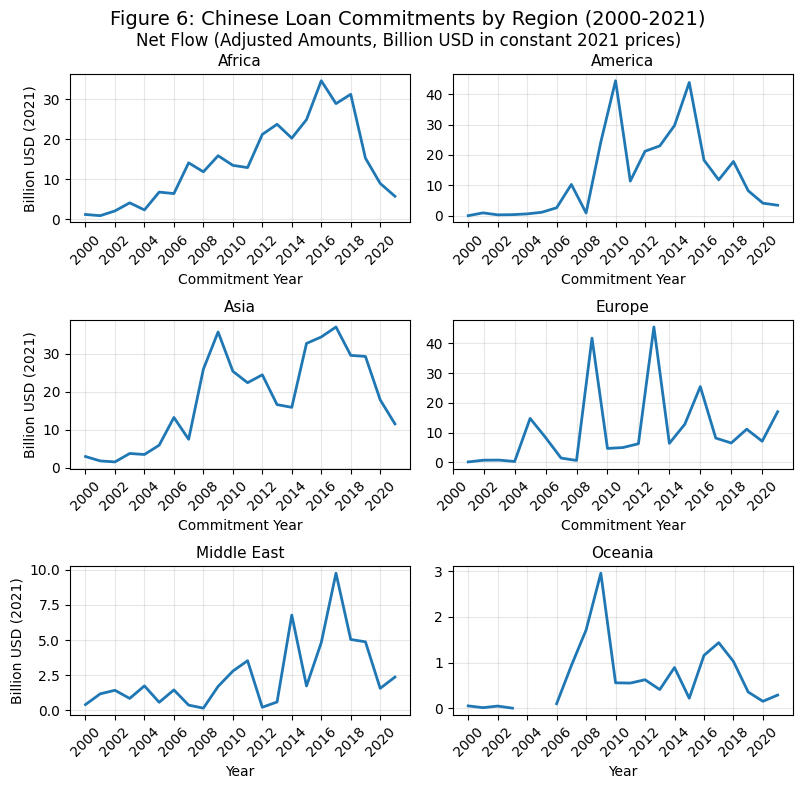

In [3]:
# Filter the rows
AidData_df = AidData[
    (AidData["Recommended For Aggregates"] == "Yes") &
    (AidData["Flow Type Simplified"] == "Loan") &
    (AidData["Commitment Year"] >= 2000)
]
# Aggregate: sum of Adjusted Amount constant 2021 USD by year and region
AidData_grouped = (
    AidData_df
    .groupby(["Commitment Year", "Recipient Region"])["Adjusted Amount (Constant USD 2021)"]
    .sum()
    .reset_index()
)
# Remove "Multi-Region"
AidData_grouped = AidData_grouped[AidData_grouped["Recipient Region"] != "Multi-Region"]

# Convert USD to billions
AidData_grouped["Adjusted Amount (Constant USD 2021)"] /= 1e9

# Pivot for plotting
AidData_pivot = AidData_grouped.pivot(
    index="Commitment Year",
    columns="Recipient Region",
    values="Adjusted Amount (Constant USD 2021)"
)

# Facet wrap plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8), sharex=False)
axes = axes.flatten()
regions = AidData_pivot.columns.sort_values()  # Sort regions

for i, region in enumerate(regions):
    if i < len(axes):
        ax = axes[i]
        AidData_pivot[region].plot(ax=ax, linewidth=2)
        ax.set_title(region, loc="center", fontsize=11)
        
        # Add vertical grid (for years)
        ax.grid(True, axis='both', alpha=0.3)
        
        # X-axis with all years labeled
        years = range(2000, 2022, 2)  # Every 2 years from 2000 to 2021
        ax.set_xticks(years)
        ax.set_xticklabels(years, rotation=45)
        
        # Format Y-axis - only for left column (even indices: 0, 2, 4)
        if i % 2 == 0:
            ax.set_ylabel("Billion USD (2021)")
        
        # X-axis label only for bottom plots
        if i >= len(axes) - 2:
            ax.set_xlabel("Year")

# Format title 
plt.suptitle(
    "Figure 6: Chinese Loan Commitments by Region (2000-2021)",
    fontsize=14,
    y=0.98
)
plt.figtext(
    0.5, 0.935,
    "Net Flow (Adjusted Amounts, Billion USD in constant 2021 prices)",
    ha='center',
    fontsize=12
)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

**Question 3b.** Show graphically which sectors Chinese lending has primarily been directed to.

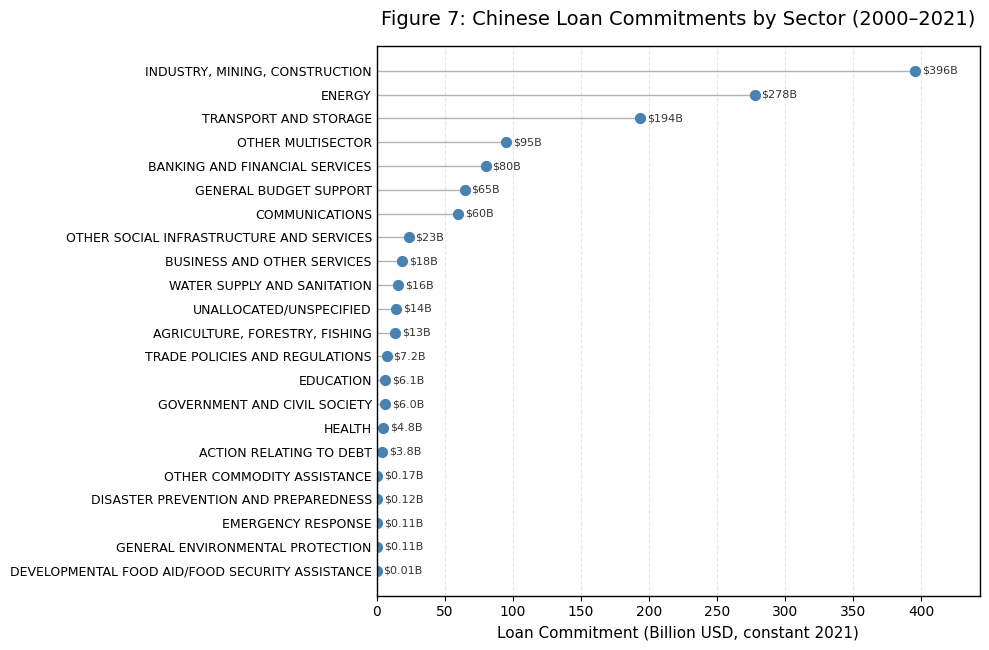

In [4]:
# 3b. Aggregate by sector
sector_df = (
    AidData_df
    .groupby("Sector Name")["Adjusted Amount (Constant USD 2021)"]
    .sum()
    .reset_index()
)
# Convert to billions and sort
sector_df["Adjusted Amount (Constant USD 2021)"] /= 1e9
sector_df = sector_df.sort_values(
    by="Adjusted Amount (Constant USD 2021)",
    ascending=True
)

# Plot horizontal lollipop with adjusted spacing
fig, ax = plt.subplots(figsize=(10, max(6, 0.3 * len(sector_df))))
# Add more space on the left for sector names
plt.subplots_adjust(left=0.3)
y_positions = range(len(sector_df))

ax.hlines(
    y=y_positions,
    xmin=0,
    xmax=sector_df["Adjusted Amount (Constant USD 2021)"],
    color="gray",
    alpha=0.6,
    linewidth=1
)
ax.scatter(
    sector_df["Adjusted Amount (Constant USD 2021)"],
    y_positions,
    color="steelblue",
    s=50
)

# Add value labels with better positioning
for y_pos, (idx, row) in enumerate(sector_df.iterrows()):
    value = row["Adjusted Amount (Constant USD 2021)"]
    
    # Format based on value size
    if value < 1:
        label = f'${value:.2f}B'
    elif value < 10:
        label = f'${value:.1f}B'
    else:
        label = f'${value:.0f}B'
    
    # Position labels with consistent spacing from dots
    ax.text(value + 5, y_pos, label, 
            va='center', ha='left', fontsize=8, color='#333333', weight='medium')

# Formatting
ax.set_yticks(y_positions)
ax.set_yticklabels(sector_df["Sector Name"], fontsize=9)
ax.set_xlabel("Loan Commitment (Billion USD, constant 2021)", fontsize=11)
ax.set_title("Figure 7: Chinese Loan Commitments by Sector (2000–2021)", fontsize=14, pad=15)

# Extend x-axis to accommodate labels
max_value = sector_df["Adjusted Amount (Constant USD 2021)"].max()
ax.set_xlim(0, max_value * 1.12)

# Add grid for easier reading
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Keep all spines (black borders) visible
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Make borders black with standard width
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(1)

# Remove y-axis ticks for cleaner look
ax.tick_params(axis='y', length=0)

# Use tight_layout
plt.tight_layout()
plt.show()

**Question 3c.** Create a table that lists the ten countries that have borrowed most from Chinese creditors in terms of their GDP.

In [9]:
import requests
import pandas as pd
import time

def fetch_world_bank_gdp(iso3_codes, start_year=2000, end_year=2024):
    """
    Fetch GDP data for multiple countries from World Bank API
    Using CONSTANT 2015 USD (NY.GDP.MKTP.KD)
    
    Note: World Bank uses 2015 as base year for constant USD.
    Your loan data uses 2021 as base year.
    """
    def get_batch(countries, start, end):
        """Fetch a single batch of GDP data"""
        # NY.GDP.MKTP.KD = GDP (constant 2015 US$)
        url = f"https://api.worldbank.org/v2/country/{';'.join(countries)}/indicator/NY.GDP.MKTP.KD"
        params = {"date": f"{start}:{end}", "format": "json", "per_page": 10000}
        
        try:
            response = requests.get(url, params=params, timeout=30)
            if response.status_code == 200:
                data = response.json()
                return data[1] if isinstance(data, list) and len(data) > 1 else []
        except Exception as e:
            print(f"  Error: {e}")
        return []
    
    # Fetch data in batches
    all_records = []
    batch_size = 20
    n_batches = (len(iso3_codes) - 1) // batch_size + 1
    
    print(f"Fetching GDP data for {len(iso3_codes)} countries (constant 2015 USD)...")
    
    for i in range(0, len(iso3_codes), batch_size):
        batch = iso3_codes[i:i+batch_size]
        print(f"  Batch {i//batch_size + 1}/{n_batches}...", end='')
        
        records = get_batch(batch, start_year, end_year)
        all_records.extend(records)
        
        print(f" {len(records)} records")
        time.sleep(0.5)  # API rate limiting
    
    return all_records

def process_gdp_records(records):
    """
    Extract ISO3 codes and GDP values from World Bank API response
    Convert GDP to billions USD (constant 2015 prices)
    """
    gdp_data = []
    
    for record in records:
        if not record or record.get('value') is None:
            continue
            
        # Extract ISO3 code
        iso3 = record.get('countryiso3code', '')
        if not iso3 and 'country' in record:
            iso3 = record['country'].get('id', '')
        
        # Only process ISO3 codes
        if len(iso3) == 3:
            gdp_data.append({
                'ISO3': iso3,
                'Year': int(record['date']),
                'GDP_Constant_Billion_USD': float(record['value']) / 1e9  # Convert to billions
            })
    
    return pd.DataFrame(gdp_data)

# Main execution
# Get unique ISO3 codes
unique_iso3 = AidData['Recipient ISO-3'].dropna().unique().tolist()
print(f"Found {len(unique_iso3)} unique countries\n")

# Fetch GDP data from World Bank
raw_records = fetch_world_bank_gdp(unique_iso3)
print(f"\nTotal records fetched: {len(raw_records)}")

# Process records into clean dataframe
gdp_df = process_gdp_records(raw_records)
print(f"Valid GDP records: {len(gdp_df)}")

# Create complete panel dataset (all country-year combinations)
years = list(range(2000, 2025))
country_year_panel = pd.MultiIndex.from_product(
    [unique_iso3, years], 
    names=['ISO3', 'Year']
).to_frame(index=False)

# Merge GDP data with panel
gdp_complete = country_year_panel.merge(gdp_df, on=['ISO3', 'Year'], how='left')

# Summary statistics
print(f"\nDataset summary:")
print(f"  Total observations: {len(gdp_complete):,}")
print(f"  GDP values available: {gdp_complete['GDP_Constant_Billion_USD'].notna().sum():,}")
print(f"  Coverage rate: {gdp_complete['GDP_Constant_Billion_USD'].notna().sum() / len(gdp_complete) * 100:.1f}%")
print(f"  Countries with data: {gdp_df['ISO3'].nunique()} out of {len(unique_iso3)}")

# Quick preview with GDP in billions
print("\nSample data (GDP in Billion USD, constant 2015 prices):")
sample = gdp_complete[gdp_complete['GDP_Constant_Billion_USD'].notna()].head(10)
sample['GDP_Constant_Billion_USD'] = sample['GDP_Constant_Billion_USD'].round(2)
print(sample)



Found 147 unique countries

Fetching GDP data for 147 countries (constant 2015 USD)...
  Batch 1/8... 500 records
  Batch 2/8... 0 records
  Batch 3/8... 500 records
  Batch 4/8... 500 records
  Batch 5/8... 0 records
  Batch 6/8... 500 records
  Batch 7/8... 500 records
  Batch 8/8... 175 records

Total records fetched: 2675
Valid GDP records: 2471

Dataset summary:
  Total observations: 3,675
  GDP values available: 2,471
  Coverage rate: 67.2%
  Countries with data: 105 out of 147

Sample data (GDP in Billion USD, constant 2015 prices):
  ISO3  Year  GDP_Constant_Billion_USD
0  AFG  2000                      6.21
1  AFG  2001                      5.62
2  AFG  2002                      7.23
3  AFG  2003                      7.87
4  AFG  2004                      7.98
5  AFG  2005                      8.87
6  AFG  2006                      9.35
7  AFG  2007                     10.64
8  AFG  2008                     11.06
9  AFG  2009                     13.43


In [19]:
# Create annual adjusted loan flows dataframe from AidData
# Filter for loans only (using your existing criteria)
adjusted_loans_df = AidData[
    (AidData["Recommended For Aggregates"] == "Yes") &
    (AidData["Flow Type Simplified"] == "Loan") &
    (AidData["Commitment Year"] >= 2000) &
    (AidData["Commitment Year"] <= 2024)
].copy()

# Aggregate adjusted loan amounts by country (ISO3) and year
annual_adjusted_loans = (adjusted_loans_df
    .groupby(['Recipient ISO-3', 'Commitment Year'])
    ['Adjusted Amount (Constant USD 2021)']
    .sum()
    .reset_index()
    .rename(columns={
        'Recipient ISO-3': 'ISO3',
        'Commitment Year': 'Year',
        'Adjusted Amount (Constant USD 2021)': 'Adjusted_Loan_Amount_USD'
    })
)

# Convert to billions
annual_adjusted_loans['Adjusted_Loan_Amount_Billion_USD'] = annual_adjusted_loans['Adjusted_Loan_Amount_USD'] / 1e9

# Create complete panel (all country-year combinations)
years = list(range(2000, 2025))
unique_iso3 = adjusted_loans_df['Recipient ISO-3'].dropna().unique().tolist()

country_year_panel = pd.MultiIndex.from_product(
    [unique_iso3, years], 
    names=['ISO3', 'Year']
).to_frame(index=False)

# Merge to get complete panel with adjusted loans (0 for years with no loans)
adjusted_loans_panel = country_year_panel.merge(
    annual_adjusted_loans[['ISO3', 'Year', 'Adjusted_Loan_Amount_Billion_USD']], 
    on=['ISO3', 'Year'], 
    how='left'
).fillna({'Adjusted_Loan_Amount_Billion_USD': 0})

# Add cumulative adjusted loans column
adjusted_loans_panel['Cumulative_Adjusted_Loan_Amount_Billion_USD'] = (
    adjusted_loans_panel
    .groupby('ISO3')['Adjusted_Loan_Amount_Billion_USD']
    .cumsum()
)

# Merge with GDP data
adjusted_loans_gdp_panel = adjusted_loans_panel.merge(
    gdp_complete[['ISO3', 'Year', 'GDP_Constant_Billion_USD']],
    on=['ISO3', 'Year'],
    how='left'
)

# Rename GDP column for clarity
adjusted_loans_gdp_panel['GDP_Constant_2015_Billion_USD'] = adjusted_loans_gdp_panel['GDP_Constant_Billion_USD']
adjusted_loans_gdp_panel.drop('GDP_Constant_Billion_USD', axis=1, inplace=True)

# Add Cumulative GDP column
adjusted_loans_gdp_panel['Cumulative_GDP_Billion_USD'] = (
    adjusted_loans_gdp_panel
    .groupby('ISO3')['GDP_Constant_2015_Billion_USD']
    .cumsum()
)

# Calculate debt ratios using adjusted loan amounts
# Annual adjusted loan to GDP ratio
adjusted_loans_gdp_panel['Annual_Adjusted_Loan_to_GDP_Ratio'] = (
    adjusted_loans_gdp_panel['Adjusted_Loan_Amount_Billion_USD'] / 
    adjusted_loans_gdp_panel['GDP_Constant_2015_Billion_USD'] * 100
)

# Cumulative adjusted loan to current GDP ratio
adjusted_loans_gdp_panel['Cumulative_Adjusted_Loan_to_Current_GDP_Ratio'] = (
    adjusted_loans_gdp_panel['Cumulative_Adjusted_Loan_Amount_Billion_USD'] / 
    adjusted_loans_gdp_panel['GDP_Constant_2015_Billion_USD'] * 100
)

# Cumulative adjusted loan to cumulative GDP ratio
adjusted_loans_gdp_panel['Cumulative_Adjusted_Loan_to_Cumulative_GDP_Ratio'] = (
    adjusted_loans_gdp_panel['Cumulative_Adjusted_Loan_Amount_Billion_USD'] / 
    adjusted_loans_gdp_panel['Cumulative_GDP_Billion_USD'] * 100
)

# Add country names
country_names = adjusted_loans_df[['Recipient ISO-3', 'Recipient']].drop_duplicates()
country_names.columns = ['ISO3', 'Country_Name']
adjusted_loans_gdp_panel = adjusted_loans_gdp_panel.merge(country_names, on='ISO3', how='left')

# Reorder columns for clarity
column_order = [
    'ISO3', 'Country_Name', 'Year',
    'Adjusted_Loan_Amount_Billion_USD',
    'Cumulative_Adjusted_Loan_Amount_Billion_USD',
    'GDP_Constant_2015_Billion_USD',
    'Cumulative_GDP_Billion_USD',
    'Annual_Adjusted_Loan_to_GDP_Ratio',
    'Cumulative_Adjusted_Loan_to_Current_GDP_Ratio',
    'Cumulative_Adjusted_Loan_to_Cumulative_GDP_Ratio'
]
adjusted_loans_gdp_panel = adjusted_loans_gdp_panel[column_order]

# Summary
print("Adjusted Loans-GDP Panel Dataset")
print("="*60)
print(f"Total observations: {len(adjusted_loans_gdp_panel):,}")
print(f"Countries: {adjusted_loans_gdp_panel['ISO3'].nunique()}")
print(f"Years: {adjusted_loans_gdp_panel['Year'].min()} - {adjusted_loans_gdp_panel['Year'].max()}")
print(f"Observations with GDP data: {adjusted_loans_gdp_panel['GDP_Constant_2015_Billion_USD'].notna().sum():,}")

# Create Table: Top 10 by Cumulative Adjusted Loan to Current GDP Ratio in 2023
print("\nTable: Top 10 Countries by Cumulative Chinese Adjusted Loan-to-GDP Ratio (2023)")
print("="*80)

top_10_2023 = (adjusted_loans_gdp_panel[
    (adjusted_loans_gdp_panel['Year'] == 2023) & 
    (adjusted_loans_gdp_panel['Cumulative_Adjusted_Loan_to_Current_GDP_Ratio'].notna()) &
    (adjusted_loans_gdp_panel['Cumulative_Adjusted_Loan_to_Current_GDP_Ratio'] > 0)
]
.nlargest(10, 'Cumulative_Adjusted_Loan_to_Current_GDP_Ratio')
.copy())

# Format the table with both ratios
display_table = pd.DataFrame({
    'Rank': range(1, len(top_10_2023) + 1),
    'Country': top_10_2023['Country_Name'].values,
    'Total Adjusted Loans (Billion USD)': top_10_2023['Cumulative_Adjusted_Loan_Amount_Billion_USD'].round(2),
    'GDP 2023 (Billion USD)': top_10_2023['GDP_Constant_2015_Billion_USD'].round(1),
    'Cumulative GDP (Billion USD)': top_10_2023['Cumulative_GDP_Billion_USD'].round(0),
    'Adjusted Loans/Current GDP (%)': top_10_2023['Cumulative_Adjusted_Loan_to_Current_GDP_Ratio'].round(1),
    'Adjusted Loans/Cumulative GDP (%)': top_10_2023['Cumulative_Adjusted_Loan_to_Cumulative_GDP_Ratio'].round(2)
})

print(display_table.to_string(index=False))

print(f"\nNote: Adjusted loan amounts exclude rollover refinancing")
print(f"Note: GDP values are in constant 2015 USD")

Adjusted Loans-GDP Panel Dataset
Total observations: 3,350
Countries: 134
Years: 2000 - 2024
Observations with GDP data: 2,240

Table: Top 10 Countries by Cumulative Chinese Adjusted Loan-to-GDP Ratio (2023)
 Rank                          Country  Total Adjusted Loans (Billion USD)  GDP 2023 (Billion USD)  Cumulative GDP (Billion USD)  Adjusted Loans/Current GDP (%)  Adjusted Loans/Cumulative GDP (%)
    1                 Marshall Islands                                5.13                     0.2                           4.0                          2416.5                             115.31
    2 Lao People's Democratic Republic                               20.58                    20.3                         286.0                           101.3                               7.20
    3                Equatorial Guinea                                9.01                     9.5                         254.0                            95.3                               3.54
    4   

**Question 3d.** What is the average interest rate charged by Chinese creditors on their overseas loans?

=== Interest Rate Data Analysis ===

Original loans with interest data: 2,627
Rescheduled loans with new rates: 0

=== Original Loan Interest Rates ===
Simple mean: 3.46%
Amount-weighted mean: 4.13%
Median: 3.00%
25th percentile: 2.00%
75th percentile: 4.69%
Range: 0.00% - 33.00%

=== Interest Rates by Loan Type ===

OOF-like:
  Simple mean: 4.20%
  Weighted mean: 4.31%
  Number of loans: 1,900
  Total amount: $765.4B

ODA-like:
  Simple mean: 1.44%
  Weighted mean: 2.24%
  Number of loans: 705
  Total amount: $69.2B

Vague (Official Finance):
  Simple mean: 3.42%
  Weighted mean: 3.83%
  Number of loans: 22
  Total amount: $1.0B


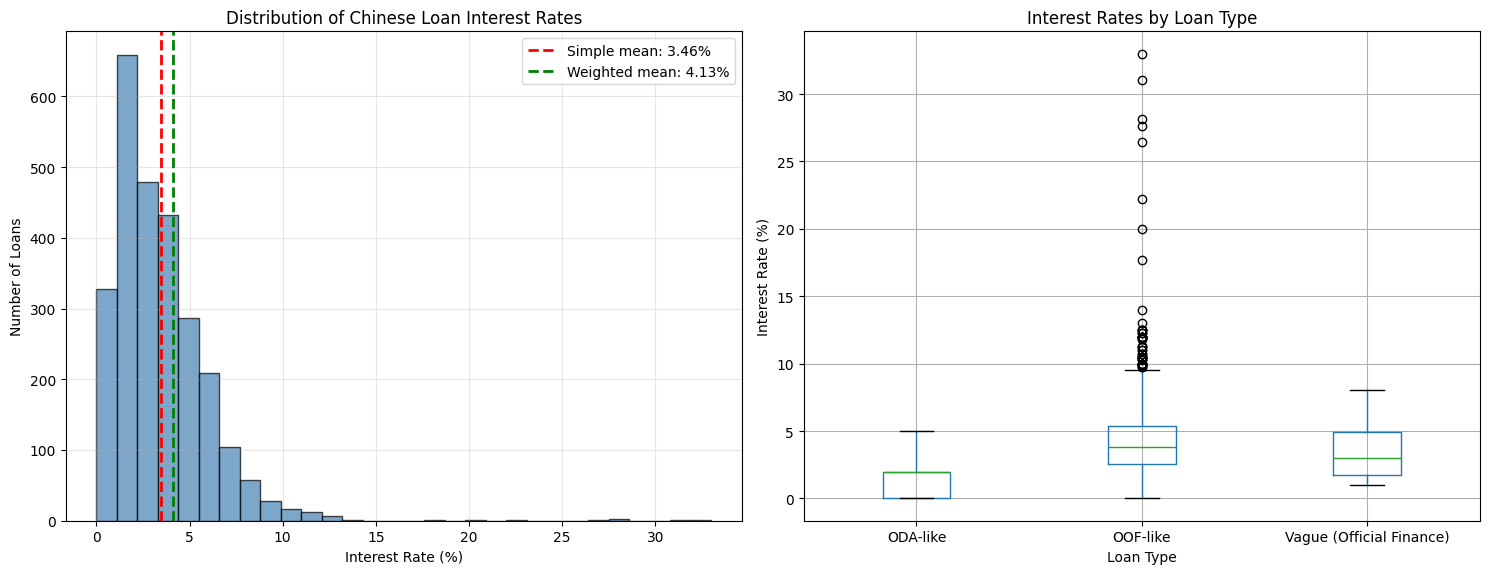

In [31]:
# Analyze Chinese Loan Interest Rates
print("=== Interest Rate Data Analysis ===\n")

# Filter for original loans only (exclude debt reschedulings)
loans = AidData[
    (AidData["Flow Type Simplified"] == "Loan") &
    (AidData["Recommended For Aggregates"] == "Yes") &
    (AidData["Interest Rate"].notna()) &
    (AidData["Flow Type"] != "Debt Rescheduling")
].copy()

# Count rescheduled loans separately
rescheduled = AidData[
    (AidData["Flow Type"] == "Debt Rescheduling") &
    (AidData["Interest Rate"].notna())
]

print(f"Original loans with interest data: {len(loans):,}")
print(f"Rescheduled loans with new rates: {len(rescheduled):,}")

if len(loans) > 0:
    # Calculate means
    simple_mean = loans["Interest Rate"].mean()
    weighted_mean = (loans["Interest Rate"] * loans["Adjusted Amount (Constant USD 2021)"]).sum() / loans["Adjusted Amount (Constant USD 2021)"].sum()
    
    # Print summary statistics
    print(f"\n=== Original Loan Interest Rates ===")
    print(f"Simple mean: {simple_mean:.2f}%")
    print(f"Amount-weighted mean: {weighted_mean:.2f}%")
    print(f"Median: {loans['Interest Rate'].median():.2f}%")
    print(f"25th percentile: {loans['Interest Rate'].quantile(0.25):.2f}%")
    print(f"75th percentile: {loans['Interest Rate'].quantile(0.75):.2f}%")
    print(f"Range: {loans['Interest Rate'].min():.2f}% - {loans['Interest Rate'].max():.2f}%")
    
    # Breakdown by Flow Class
    print("\n=== Interest Rates by Loan Type ===")
    for flow_class in loans["Flow Class"].dropna().unique():
        class_data = loans[loans["Flow Class"] == flow_class]
        class_simple_mean = class_data["Interest Rate"].mean()
        class_weighted_mean = (class_data["Interest Rate"] * class_data["Adjusted Amount (Constant USD 2021)"]).sum() / class_data["Adjusted Amount (Constant USD 2021)"].sum()
        
        print(f"\n{flow_class}:")
        print(f"  Simple mean: {class_simple_mean:.2f}%")
        print(f"  Weighted mean: {class_weighted_mean:.2f}%")
        print(f"  Number of loans: {len(class_data):,}")
        print(f"  Total amount: ${class_data['Adjusted Amount (Constant USD 2021)'].sum()/1e9:.1f}B")
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram of interest rates
    ax1.hist(loans["Interest Rate"], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(simple_avg, color='red', linestyle='--', linewidth=2, label=f'Simple mean: {simple_avg:.2f}%')
    ax1.axvline(weighted_avg, color='green', linestyle='--', linewidth=2, label=f'Weighted mean: {weighted_avg:.2f}%')
    ax1.set_xlabel("Interest Rate (%)")
    ax1.set_ylabel("Number of Loans")
    ax1.set_title("Distribution of Chinese Loan Interest Rates")
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Box plot by loan type
    loans.boxplot(column="Interest Rate", by="Flow Class", ax=ax2)
    ax2.set_xlabel("Loan Type")
    ax2.set_ylabel("Interest Rate (%)")
    ax2.set_title("Interest Rates by Loan Type")
    plt.suptitle("")  # Remove default title
    
    plt.tight_layout()
    plt.show()
    
    # Report on rescheduled loans if any
    if len(rescheduled) > 0:
        print(f"\n=== Rescheduled Loan Rates ===")
        print(f"Average new rate after rescheduling: {rescheduled['Interest Rate'].mean():.2f}%")
        print(f"Note: These represent modified rates, not original terms")